In [1]:
import os
import joblib
import pickle

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
filename = '../processed_data/m1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'

with open(filename, 'rb') as file:
    spike_times_all_neurons = joblib.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# Transpose into (71999, 90)
spike_times_all_neurons = spike_times_all_neurons.T

# Truncate two hour m1 recording to one hour l5 recording into (36000, 46), 
# 0th to 45th L5/6, 46th to 89th L2/3, 89th being the most shallow
spike_times_l5_neurons_1h = spike_times_all_neurons[:36000, :46]

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_l5_neurons_1h_zscored = stats.zscore(spike_times_l5_neurons_1h) # Default axis is 0

data = spike_times_l5_neurons_1h_zscored
print(f'Spike times are binned into shape for hmm: {data.shape}')

Spike times are binned into shape for hmm: (36000, 46)


In [3]:
max_model_dir = "../hmm_models/hmm_max/"

In [7]:
hmms_num = 49

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def rf_f1_score(hmm_model, data, limit_count=100, verbose=False):
    Z2 = hmm_model.predict(data)
    X = data.copy()
    y = Z2.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if verbose:
        print(X.shape, y.shape, [len(np.where(y == s)[0]) for s in np.unique(Z2)])
    np.random.seed(2022)
    y_subsampled = []
    X_subsampled = []
    for s in np.unique(Z2):
        idx_s = np.where(y==s)[0]
        try:
            sampled_idx_s = np.random.choice(len(idx_s), limit_count, replace=False)
        except:
            sampled_idx_s = np.random.choice(len(idx_s), len(idx_s), replace=False)
        y_subsampled.append(y[idx_s[sampled_idx_s]])
        X_subsampled.append(X[idx_s[sampled_idx_s], :])
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)
    X_train, X_test, y_train, y_test = train_test_split(np.vstack(X_subsampled), np.hstack(y_subsampled), 
                                                        test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    # print(50*'=')
    # print(f'average: {f1_score(y_test, predict, average="macro")}')
    # print(50*'-')
    # print(f'indiv:{f1_score(y_test, predict, average=None)}')
    # print(50*'=')

    return f1_score(y_test, predict, average="macro")

In [16]:
percentage_hmm_f1_score_above_chance = []
for i in range(hmms_num):
    # Load model
    K = i + 1 # Offset indexing by 1
    hmm_mrg = pickle.load(open(os.path.join(max_model_dir, f"1h_l5_possion_merged_{K}_latents" + ".hmm"), "rb"))
    # Compute the percentage by which the f1 score out of random forests is higher than the corresponding chance
    chance = 1.0/K
    percentage_hmm_f1_score_above_chance.append((rf_f1_score(hmm_mrg, data, limit_count=1360, verbose=False) - chance)*K*100)

Text(0.5, 1.0, 'Percentage by which f1 score is higher than chance')

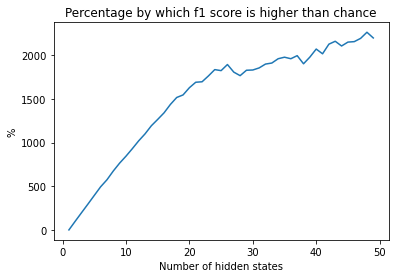

In [25]:
plt.plot([x+1 for x in range(K)], percentage_hmm_f1_score_above_chance)
plt.xlabel('Number of hidden states')
plt.ylabel('%')
plt.title('Percentage by which f1 score is higher than chance')

The elbow point occurs at (26, 1893.2918317844947)

In [27]:
hmm_f1_score_ratio_chance = []
for i in range(hmms_num):
    # Load model
    K = i + 1 # Offset indexing by 1
    hmm_mrg = pickle.load(open(os.path.join(max_model_dir, f"1h_l5_possion_merged_{K}_latents" + ".hmm"), "rb"))
    # Compute the ratio between the f1 score out of random forests and the corresponding chance
    hmm_f1_score_ratio_chance.append(rf_f1_score(hmm_mrg, data, limit_count=1360, verbose=False)*K)

Text(0.5, 1.0, 'f1 score ratio chance')

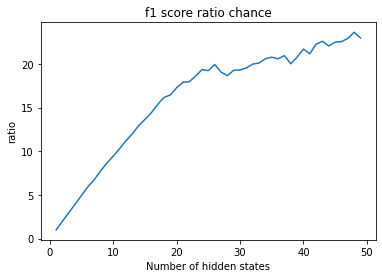

In [31]:
plt.plot([x+1 for x in range(K)], hmm_f1_score_ratio_chance)
plt.xlabel('Number of hidden states')
plt.ylabel('ratio')
plt.title('f1 score ratio chance')

The elbow point occurs at (26, 19.932918317844948)